In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")
from itertools import cycle
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans

# Loading The Data: 2014 Boston Marathon Results

In [36]:
marathon = pd.read_csv('results.csv')
marathon.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [37]:
marathon.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

# Sampling

# Choose some useful variables and order them

In [38]:
marathon['gender'] = marathon['gender'].map({'F': 1, 'M': 0})
marathon.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,0,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,1,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,0,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,1,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,0,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [39]:
marathon = marathon.drop(['bib','city','country','ctz','division','genderdiv','overall','name','state'], 1)

In [40]:
columns = marathon[['5k','10k','20k','25k','30k','35k','40k','gender','age','half','official','pace']]

for column in columns: 
    marathon[column] = pd.to_numeric(marathon[column], errors='coerce')

In [41]:
marathon.dtypes

10k         float64
25k         float64
gender        int64
age           int64
official    float64
35k         float64
pace        float64
30k         float64
5k          float64
half        float64
20k         float64
40k         float64
dtype: object

In [42]:
marathon.head()

,10k,25k,gender,age,official,35k,pace,30k,5k,half,20k,40k
0,17.37,47.67,0,47,85.25,71.40,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,82.43,1,33,138.95,116.37,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,45.80,0,41,80.60,67.42,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,82.43,1,24,140.58,116.37,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,46.37,0,40,81.23,67.83,3.10,57.03,8.02,38.60,36.58,76.72


In [43]:
marathon = marathon.dropna()

In [44]:
marathon.describe()

,10k,25k,gender,age,official,35k,pace,30k,5k,half,20k,40k
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000
mean,51.629039,133.581175,0.447565,42.385067,241.952383,196.033373,9.236463,163.894883,25.678261,111.211481,105.321404,228.189990
std,8.710102,25.571480,0.497251,11.299795,50.842552,40.775036,1.939150,32.889354,4.215381,20.306387,19.159500,48.074493
min,16.620000,45.800000,0.000000,18.000000,80.600000,67.420000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.370000,115.430000,0.000000,33.000000,205.300000,166.950000,7.830000,140.520000,22.620000,96.750000,91.670000,193.620000
50%,50.280000,128.850000,0.000000,42.000000,231.980000,187.850000,8.850000,157.500000,25.050000,107.680000,102.000000,218.470000
75%,57.000000,147.700000,1.000000,50.000000,272.200000,219.370000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000
max,112.380000,289.020000,1.000000,81.000000,538.880000,449.330000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


# Normalization: Preprocessing

In [45]:
X_normalized = normalize(marathon)
X_normalized_df = pd.DataFrame(normalize(marathon), columns = marathon.columns)

# K-Means

In [48]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10)
km.fit(X_normalized_df)
x = km.fit_predict(X_normalized_df)
x

array([1, 1, 1, ..., 2, 2, 1])

In [49]:
marathon["Cluster"]= x
marathon.head()

,10k,25k,gender,age,official,35k,pace,30k,5k,half,20k,40k,Cluster
0,17.37,47.67,0,47,85.25,71.40,3.27,59.18,8.02,39.72,37.65,80.43,1
1,32.58,82.43,1,33,138.95,116.37,5.30,99.33,16.22,69.47,65.83,132.10,1
2,16.62,45.80,0,41,80.60,67.42,3.08,56.45,7.75,38.03,36.10,76.10,1
3,32.57,82.43,1,24,140.58,116.37,5.37,99.33,16.20,69.47,65.83,132.95,3
4,17.12,46.37,0,40,81.23,67.83,3.10,57.03,8.02,38.60,36.58,76.72,1


In [50]:
marathon = marathon.sort_values(['Cluster'])
marathon

,10k,25k,gender,age,official,35k,pace,30k,5k,half,20k,40k,Cluster
15910,53.82,140.28,1,41,259.52,209.95,9.90,173.83,26.87,115.60,109.40,245.02,0
7739,44.63,114.80,0,42,216.52,172.50,8.27,142.17,22.28,95.65,90.63,204.42,0
21542,58.27,149.07,1,56,288.60,223.07,11.02,184.75,28.83,124.48,117.78,266.95,0
21543,60.68,179.15,1,57,348.13,275.95,13.28,225.02,28.67,145.12,137.38,325.18,0
14932,49.87,130.95,1,43,245.80,198.08,9.38,162.35,24.45,109.27,103.63,229.63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,41.93,105.40,1,30,180.80,149.47,6.90,127.20,20.85,88.75,84.15,171.55,3
20030,55.12,139.52,1,50,252.75,207.13,9.65,172.05,27.15,116.68,110.43,239.68,3
4403,42.07,105.70,0,33,183.88,149.67,7.02,127.58,21.23,88.75,84.03,173.92,3
11641,49.38,122.07,1,25,205.83,171.27,7.87,146.48,24.67,103.28,98.08,195.43,3


In [58]:
df0 = marathon[(marathon.Cluster == 0)]
df1 = marathon[(marathon.Cluster == 1)]
df2 = marathon[(marathon.Cluster == 2)]
df3 = marathon[(marathon.Cluster == 3)]

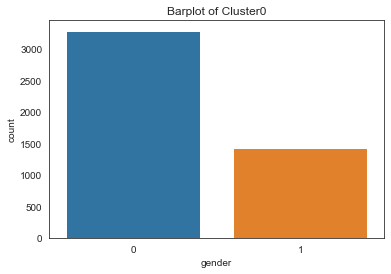

In [60]:
plt.title("Gender Barplot of Cluster0")
sns.countplot(x="gender", data=df0)

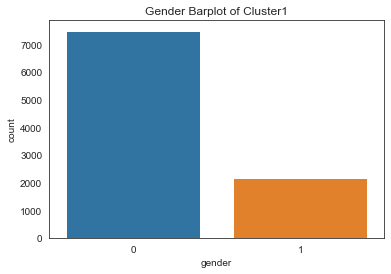

In [61]:
plt.title("Gender Barplot of Cluster1")
sns.countplot(x="gender", data=df1)

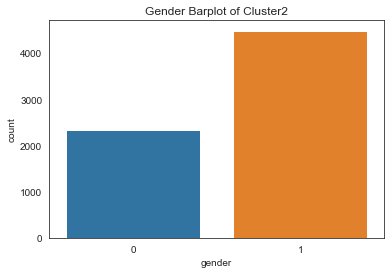

In [62]:
plt.title("Gender Barplot of Cluster2")
sns.countplot(x="gender", data=df2)

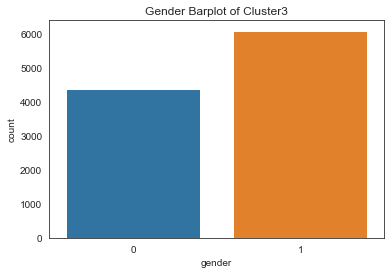

In [63]:
plt.title("Gender Barplot of Cluster3")
sns.countplot(x="gender", data=df3)

In [69]:
bins= [0,18,26,40,110]
labels = ['1','2','3','4']
df0['ageGroup'] = pd.cut(df0['age'], bins=bins, labels=labels, right=False)
df1['ageGroup'] = pd.cut(df1['age'], bins=bins, labels=labels, right=False)
df2['ageGroup'] = pd.cut(df2['age'], bins=bins, labels=labels, right=False)
df3['ageGroup'] = pd.cut(df3['age'], bins=bins, labels=labels, right=False)
print(df0)

         10k     25k  gender  age  official     35k   pace     30k     5k  \
15910  53.82  140.28       1   41    259.52  209.95   9.90  173.83  26.87   
7739   44.63  114.80       0   42    216.52  172.50   8.27  142.17  22.28   
21542  58.27  149.07       1   56    288.60  223.07  11.02  184.75  28.83   
21543  60.68  179.15       1   57    348.13  275.95  13.28  225.02  28.67   
14932  49.87  130.95       1   43    245.80  198.08   9.38  162.35  24.45   
...      ...     ...     ...  ...       ...     ...    ...     ...    ...   
25733  60.65  157.70       0   44    296.60  236.48  11.32  195.58  29.90   
25913  55.30  134.55       0   34    266.83  197.92  10.18  164.02  28.63   
25907  60.55  161.78       1   52    297.75  239.95  11.37  200.25  30.07   
25736  63.48  172.83       1   40    340.50  267.30  13.00  213.27  31.85   
25737  54.48  145.63       0   55    277.77  217.88  10.60  180.48  27.17   

         half     20k     40k  Cluster ageGroup  
15910  115.60  109.40  24

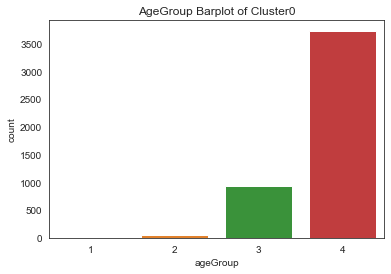

In [70]:
plt.title("AgeGroup Barplot of Cluster0")
sns.countplot(x="ageGroup", data=df0)

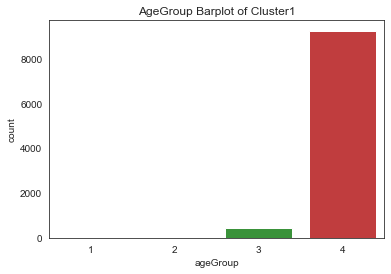

In [71]:
plt.title("AgeGroup Barplot of Cluster1")
sns.countplot(x="ageGroup", data=df1)

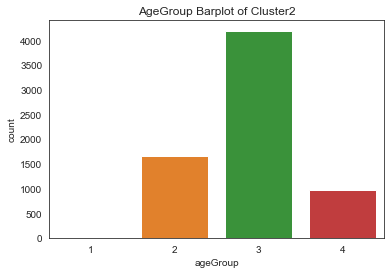

In [72]:
plt.title("AgeGroup Barplot of Cluster2")
sns.countplot(x="ageGroup", data=df2)

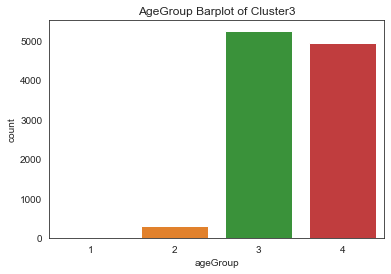

In [74]:
plt.title("AgeGroup Barplot of Cluster3")
sns.countplot(x="ageGroup", data=df3)